# Hands-on: Definição do tamanho da melhor janela para filtragem dos desvanecimentos do canal banda estreita

### Objetivos
As metas desse tutorial são ajudar o usuário a:
* Apresentar a geração de uma série temporal sintética com valores de potência recebida em função da distância, para caracterizar o Desvanecimento de Larga Escala (Perda de Percurso, Sombreamento) e Pequena Escala do canal;
* Compreender e aplicar a técnica do VEGA utilizada para encontrar o tamanho da melhor janela de filtragem dos desvanecimentos de pequena e larga escala do canal.

## Parte 1: Geração do Canal Sintético

Crie um arquivo com nome fGeraCanal.m contendo o script apresentado na célula seguinte. A função apresenta as seguintes entradas e saídas:

ENTRADAS:
   - nPoints: Número de amostras
   - totalLength: distância máxima da rota
   - P0: potência de referência medida na distância d0
   - d0: distância d0 de referência
   - n: expoente de perda de percurso
   - sigma: desvio padrão do sombreamento lognormal [dB]
   - Tamanho da janela de correlação do sombreamento [amostras]
   - p: parâmetro da pdf
   - dMed: distância entre pontos de medição (totalLength/nPoints)
   - txPower: potência de transmissão em dBm
   - pdftype: tipo de pdf

SAÍDAS:
   - vtDist: pontos de medição [m]
   - vtPathLoss: amostras da perda de percurso
   - vtShad: amostras do somrbeamento
   - fading: amostras do desvanecimento de pequena escala
   - vtPrx: potência recebida com o canal completo


In [3]:
%%file fGeraCanal.m
function [vtDist, vtPathLoss, vtShad, vtFastFading, vtPrxdBm] = fGeraCanal(sPar)

% Parser dos parâmetros de entrada
fc = sPar.fc;                      % Frequência da Portadora  
totalLength = sPar.totalLength;    % Distância final da rota de medição (m)
d0 = sPar.d0;                      % distância de referência d0 (m)
nPoints = sPar.nPoints;            % Número de amostras da rota de medição
dMed = (totalLength-d0)/(nPoints-1);   % Distância entre pontos de medição (m)
p0 = sPar.P0;                      % Potência medida na distância de referência d0 (em dBm)
n = sPar.n;                        % Expoente de perda de percurso
sigmaShad = sPar.sigmaShad;        % Desvio padrão do shadowing em dB
nSampShadW = ceil(sPar.nSampShadW); % Tamanho da janela de correlação do shadowing
txPower = sPar.txPower;            % Potência de transmissão (dBm)
pdftype = sPar.pdftype;            % Tipo de pdf (Nakagami, Rician, Rayleigh, Weibull)
s1 = sPar.p;                       % Parâmetro "sigma 1" da pdf Rician
s2 = s1;                           % Parâmetro "sigma 2" da pdf Rician
sigma = sPar.p;                    % Parâmetro "sigma" da pdf Rayleigh
m = sPar.p;                        % Parâmetro "m" da pdf Nakagami
a = sPar.p;                        % Parâmetro "a" da pdf Weibull
b = sPar.b;                        % Parâmetro "b" da pdf Weibull

% Vetor de distância das medições em relação ao transmissor
vtDist = d0:dMed:totalLength;
nSamples = length(vtDist);

% Geração da Perda de percurso (determinística)
vtPathLoss = p0 + (42.6 + 26.*log10(vtDist./d0) + 20.*log10(fc)); % Modelo COST 231 Considerando visada direta (LOS)
%vtPathLoss = p0 + 10*n*log10(vtDist./d0);

% Geração do Sombreamento
nShadowSamples = floor(nSamples/nSampShadW)+1;
shadowing = sigmaShad*randn(1,nShadowSamples);
% Amostras para a última janela
restShadowing = sigmaShad*randn(1,1)*ones(1,mod(nSamples,nSampShadW));
% Repetição do mesmo valor de sombreamento durante a janela de correlação
shadowing = ones(nSampShadW,1)*shadowing;
% Amostras organizadas em um vetor
shadowing = [reshape(shadowing,1,nShadowSamples*nSampShadW),restShadowing];
% Filtragem para evitar variação abrupta do sombreamento
jan = nSampShadW/2;
iCont = 1;
for i = jan+1:nSamples+nSampShadW-jan
    vtShad(iCont) = mean(shadowing(i-jan:i+jan)); %diminuir a variação brusca do sombreamento
    iCont = iCont+1;
end
% Ajuste do desvio padrão depois do filtro de correlação do sombreamento
vtShad = vtShad*std(shadowing)/std(vtShad);
vtShad = vtShad - mean(vtShad)+ mean(shadowing);

% Geração do desvanecimento de pequena escala
switch pdftype
    case 'Nakagami'
        pdfEquation = @(x)((2.*m.^m)./(gamma(m))).*x.^(2.*m-1).*exp(-(m.*x.^2));
    case 'Rayleigh'
        pdfEquation = @(x) (x./sigma.^2).*exp((-x.^2)/(2.*(sigma.^2)));
    case 'Weibull'
        pdfEquation = @(x) (b/a).*(((x)./a).^(b-1)).*exp(-((x)./a).^b);
    case 'Rician'
        pdfEquation = @(x) (x ./ (s1.^2)) .*exp(-0.5 * (x.^2 + s2.^2) ./ ...
                      (s1.^2)) .*besseli(0, x .* s2 ./ (s1.^2));
end
normEnvelope = slicesample(1,nSamples,'pdf',pdfEquation);
vtFastFading=20.*log10(normEnvelope');

% Cálculo da Potência recebida
txPower = txPower*ones(1,nSamples);
vtPrxdBm = txPower-vtPathLoss+vtShad+vtFastFading; % Potência recebida

% Salva variáveis do canal no Matlab
save([sPar.chFileName '.mat'],'vtDist', 'vtPathLoss', 'vtShad', 'vtFastFading', 'vtPrxdBm');

Created file 'C:\Users\Mac_l\Meu_Drive\pesquisas_jose_marcos\doutorado\disciplinas\radio_propagacao\Tarefas\Entrega_02\code\Jupyter Notebook\fGeraCanal.m'.


## Parte 2: Definição do tamanho da melhor janela pelo método do VEGA

Ler o artigo ["Generalization of the Lee Method for the Analysis of the Signal Variability"](https://www.researchgate.net/publication/224315481_Generalization_of_the_Lee_Method_for_the_Analysis_of_the_Signal_Variability) para compreender o desenvolvimento do script.  

### Geração do Canal

In [4]:
% Parâmetros para geração do canal sintético
sPar.fc = 1.359;                          % Carrier frequency (MHz)
cc = 3e8;                                 % Light speed (m/s) 
lambda = cc/(sPar.fc*1e6);                % Wavelength (m)
dMod = 0.2*44;                        % Sampling spacing (m)
sPar.lenShadWindow = 10*lambda;           % Tamanho da janela de correlação do shadowing (colocar em função da distância de correlação)
sPar.nSampShadW = sPar.lenShadWindow/dMod;% Número de amostras numa janela de correlação do shadowing
sPar.d0 = 5;                              % distância de referência d0 (m)
sPar.P0 = 0;                              % Potência medida na distância de referência d0 (em dBm)
sPar.nPoints = 50000;                     % Número de amostras da rota de medição
sPar.totalLength = sPar.nPoints*dMod;     % Distância final da rota de medição (m)
sPar.n = 4;                               % Expoente de perda de percurso
sPar.sigmaShad = 6;                       % Desvio padrão do shadowing em dB
sPar.p = 4;                               % Parâmetro da pdf: sigma(Rayleigh); m (Nakagami); a(Weibull); s(Rician); ...)
sPar.b = 1;                               % Parâmetro "b" da pdf Weibull
sPar.txPower = 0;                         % Potência de transmissão (dBm)
sPar.chFileName  = 'Prx_sintetic';        % Nome do arquivo gerado com as amostras do canal
sPar.pdftype = 'Rayleigh';                % Tipo de pdf (Nakagami, Rician, Rayleigh, Weibull)
%sPar.pdftype = 'Nakagami';
%sPar.pdftype = 'Rician';

In [6]:
% Chama função que gera o canal sintético
[vtDist, vtPathLossMod, vtShadMod, vtFastFadMod, vtPrx] = fGeraCanal(sPar);
stdShadMod=std(vtShadMod); % Desvio Padrão do Sombreamento do Canal Modelo
meanShadMod=mean(vtShadMod); % Média do Desv. Larga. Escl do Canal Modelo
stdFastFadMod=std(vtFastFadMod); % Desvio Padrão do Desv. Peq. Escl do Canal Modelo
meanFastFadMod=mean(vtFastFadMod); % Média do Desv. Peq. Escl do Canal Modelo
meanChMod=mean(vtPrx); % Média do Canal Modelo

### Laço de repetição para geração da curva 1-sigma Spreading

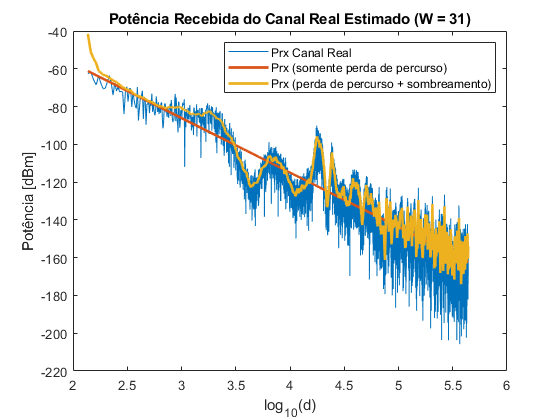

In [7]:
% Tamanhos das Janelas de estimação (em função do espaçamento entre amostras)
vtW = [2:1:150]; 

for iw = 1:length(vtW) 
%% Cálculo das médias estimadas (r) [dBm]
vtPrx_mW = 10.^(vtPrx/10); % Transforma a potência de dBm em mWatts
vtEstMean = []; % Vetor para as médias estimadas (r)

% Média por Janela Móvel
dMeiaJanela = floor(vtW(iw)/2);  % Meia janela
nSamples = length(vtPrx_mW);
ij = 1;
for ik = dMeiaJanela + 1 : nSamples - dMeiaJanela
    vtEstMean(ij) = 10*log10(mean(vtPrx_mW(ik-dMeiaJanela:ik+dMeiaJanela)));
    ij = ij + 1;
end

%% Cálculo da Média Verdadeira Aproximada (m')
vtEstMean_mW = 10.^(vtEstMean/10); % Transforma a potência de dBm em mWatts
vtTrueMean = []; % vetor para a Média Verdadeira Aproximada

% Janela Móvel para obter a média verdadeira aproximada
lenEstMean=length(vtEstMean);
ij = 1; 
for ik = dMeiaJanela + 1 : lenEstMean - dMeiaJanela
    vtTrueMean(ij) = 10*log10(mean(vtEstMean_mW(ik-dMeiaJanela:ik+dMeiaJanela)));
    ij = ij + 1;
end
% Ajuste no tamanho dos vetores devido a filtragem
vtEstMeanAjust = vtEstMean( dMeiaJanela+1 : lenEstMean-dMeiaJanela );

%% Cálculo das Médias Estimadas Normalizadas (r_norm) [dBm]
vtEstMeanNorm = vtEstMeanAjust - vtTrueMean;

%% Cálculo do 1 sigma_m Spread
stdEstMeanNorm = std(10.^(vtEstMeanNorm/10));
sigmaSpread(iw) = 20*log10((1+stdEstMeanNorm)/(1-stdEstMeanNorm));

%% Autocorrelação para encontrar "d"
[aCorr, lags] = autocorr(vtEstMeanNorm,'NumLags',sPar.nPoints/100);

% Valor de d para uma correlação de 0.2
indexD0p2 = find(aCorr<=0.2, 1, 'first');
vtD0p2(iw) = (indexD0p2-1)*dMod; %vetor com os valores de "d" para cada tamanho de janela

% Valor de d para o first null
indexD0p0 = find(aCorr<=0, 1, 'first');
vtD0p0(iw) = (indexD0p0-1)*dMod; %vetor com os valores de "d" para cada tamanho de janela

%% Cálculo do desvanecimento lento (Larga Escala) [dBm]
% Desvanecimento de larga escala: perda de percurso + sombreamento 
vtSlowFading = []; % Vetor para o Desvanecimento de Larga Escala

% Média por Janela Móvel (Filtragem)
dMeiaJanela = floor(vtW(iw)/2);  % Meia janela
ij = 1;
for ik = dMeiaJanela + 1 : nSamples - dMeiaJanela
    vtSlowFading(ij) = 10*log10(mean(vtPrx_mW(ik-dMeiaJanela:ik+dMeiaJanela)));
    ij = ij + 1;
end

% Ajuste no tamanho dos vetores devido a filtragem
vtDistAjust = vtDist( dMeiaJanela+1 : nSamples-dMeiaJanela );
vtPrxAjust = vtPrx( dMeiaJanela+1 : nSamples-dMeiaJanela );
vtShadModAjust = vtShadMod(dMeiaJanela+1 : nSamples-dMeiaJanela );
vtFastModAjust = vtFastFadMod(dMeiaJanela+1 : nSamples-dMeiaJanela );

%% Cálculo do Desvanecimento Rápido (Pequena Escala) [dBm]
vtFastFading = vtPrxAjust - vtSlowFading;

% Para verificar o RMSE/Plot dos vetores de Desvanecimento de Pequena Escala
vtFastFadingPlot(iw,1:length(vtFastFading)) = vtFastFading;
vtFastModAjustPlot(iw,1:length(vtFastFading)) = vtFastModAjust;

%% Cálculo da reta e coeficiente de perda de percurso
vtDistAjustLog = log10(vtDistAjust);
% Cálculo do coeficiente da reta que melhor caracteriza a perda de percurso
dCoefReta = polyfit(vtDistAjustLog,vtPrxAjust,1);
% Expoente de perda de percurso estimado
dNEst(iw) = -dCoefReta(1)/10;
% Perda de percurso estimada para os pontos de medição
vtPathLoss = polyval(dCoefReta,vtDistAjustLog);  

%% Cálculo do Desvanecimento por Sombreamento
vtShadowing = vtSlowFading - vtPathLoss;
vtFastFading2 = vtPrxAjust - vtShadowing - vtPathLoss;

% Para verificar o RMSE/Plot dos vetores de Sombreamento
vtShadowingPlot(iw,1:length(vtShadowing)) = vtShadowing;
vtShadModAjustPlot(iw,1:length(vtShadowing)) = vtShadModAjust;

%% Cálculos de Parâmetros
% Calcula a variância do sombreamento estimado
stdShad(iw) = std(10.^(vtShadowing/10));
% Calcula a variância do Desvanecimento Rápido estimado
stdFastFad(iw) = std(10.^(vtFastFading/10));
%Calcula erro do shadowing
rmseShad(iw) = sqrt( sum( (vtShadModAjust-vtShadowing).^2) / numel(vtShadModAjust) );
%Calcula erro do Fast Fading
movAvOffset = mean(vtSlowFading)-mean(sPar.txPower-vtPathLossMod+vtShadMod); % offset da média gerado pelo filtro de janela móvel
rmseFastFad(iw) = sqrt( sum( (vtFastModAjust-vtFastFading-movAvOffset).^2) / numel(vtFastModAjust) );
%%

%% Plot de Potência do Canal Real / Desvanecimentos Estimados 
plotOn=1; 
windowPlot = 30; %tamanho da janela para o plot
if plotOn==1
    if iw == windowPlot-1  
    figure;
    % Potência recebida do canal real
    plot(vtDistAjustLog,vtPrxAjust); hold all;
    % Potência recebida da perda de percurso
    plot(vtDistAjustLog,vtPathLoss,'linewidth', 2)
    % Potência recebida da perda de percurso e sombreamento
    plot(vtDistAjustLog,vtSlowFading,'linewidth', 2)
    xlabel('log_{10}(d)');
    ylabel('Potência [dBm]');
    legend('Prx Canal Real', 'Prx (somente perda de percurso)', 'Prx (perda de percurso + sombreamento)');
    title(strcat("Potência Recebida do Canal Real Estimado (W = ", num2str(vtW(iw)), ")"));
    end
end
end

### Valor da Melhor Janela

In [9]:
%% Best Window 1-sigma Spread
% Encontra o tamanho ótimo da janela (menor valor da curva de 1 sigma spread)
[minSigmaSpread,minIndxSigma] = min(sigmaSpread);
bestWindow = vtW(minIndxSigma); % quantidade de amostras da melhor janela
% O tamanho da melhor janela é = (quantidade de amostras-1)*espaçamento entre amostras
disp(strcat("O tamanho da janela para o menor valor do 1-sigma Spreading é: ", num2str((bestWindow-1)*dMod/lambda)," ", char(955)))

%% Melhor janela relativa ao Canal Modelo (menor rmse do sombreamento)
[minRmseShad, minIndx]=min(rmseShad);
disp(strcat("O tamanho da janela Modelo (RMSE) para o sombreamento       é: ", num2str(vtW(minIndx)*dMod/lambda)," ", char(955)))

%% Melhor janela relativa ao Canal Modelo (menor rmse do Fast Fading)
[minRmseFast, minIndxFast]=min(rmseFastFad);
disp(strcat("O tamanho da janela Modelo (RMSE) para pequena escala       é: ", num2str(vtW(minIndxFast)*dMod/lambda)," ", char(955)))


O tamanho da janela para o menor valor do 1-sigma Spreading é: 2.5912 λ
O tamanho da janela Modelo (RMSE) para o sombreamento       é: 1.6743 λ
O tamanho da janela Modelo (RMSE) para pequena escala       é: 3.3486 λ



### Cálculo da menor distância entre amostras descorrelacionadas ("d")

In [10]:
%% Distance d between uncorrelated samples
% Cálculo das médias estimadas (r) [dBm]
vtEstMeanBestW = []; % Vetor para as médias estimadas (r)

% Média por Janela Móvel
dMeiaJanela = floor(bestWindow/2);  % Meia janela
nSamples = length(vtPrx_mW);
ij = 1;
for ik = dMeiaJanela + 1 : nSamples - dMeiaJanela
    vtEstMeanBestW(ij) = 10*log10(mean(vtPrx_mW(ik-dMeiaJanela:ik+dMeiaJanela)));
    ij = ij + 1;
end

% Cálculo da Média Verdadeira Aproximada (m')
vtEstMean_mW = 10.^(vtEstMeanBestW/10); % Transforma a potência de dBm em mWatts
vtTrueMeanBestW = []; % vetor para a Média Verdadeira Aproximada

% Janela Móvel para obter a média verdadeira aproximada
lenEstMean=length(vtEstMeanBestW);
ij = 1; 
for ik = dMeiaJanela + 1 : lenEstMean - dMeiaJanela
    vtTrueMeanBestW(ij) = 10*log10(mean(vtEstMean_mW(ik-dMeiaJanela:ik+dMeiaJanela)));
    ij = ij + 1;
end
% Ajuste no tamanho dos vetores devido a filtragem
vtEstMeanAjustBestW = vtEstMeanBestW( dMeiaJanela+1 : lenEstMean-dMeiaJanela );
% Cálculo das Médias Estimadas Normalizadas (r_norm) [dBm]
vtEstMeanNormBestW = vtEstMeanAjustBestW - vtTrueMeanBestW;
% Autocorrelação para encontrar "d"
[aCorrBestW, lagsBW] = autocorr(10.^(vtEstMeanNormBestW/10),'NumLags',sPar.nPoints/100);

In [12]:
% Valor de d para o menor vale da função de autocorrelação
aCorrInvert = max(aCorrBestW) - aCorrBestW;
[pksBW, locsBW] = findpeaks(aCorrInvert,lagsBW,'MinPeakDistance',100);
indexD = locsBW(1);
dMinVale = (locsBW(1)-1)*dMod;
%disp(strcat("A distância para o menor vale da função de autocorrelação   é: ", num2str(dMinVale/lambda)," ", char(955)))

% Valor de d para uma correlação de 0.2
indexD0p2 = find(aCorrBestW<=0.2, 1, 'first');
d0p2 = (indexD0p2-1)*dMod;
disp(strcat("A distância entre as amostras não correl. (d) (correl. 0.2) é: ", num2str(d0p2/lambda)," ", char(955)))

% Valor de d para o first null
indexD0p0 = find(aCorrBestW<=0, 1, 'first');
d0p0 = (indexD0p0-1)*dMod; %vetor com os valores de "d" para cada tamanho de janela
disp(strcat("A distância entre as amostras não correl. (d) (first null)  é: ", num2str(d0p0/lambda)," ", char(955)))

A distância entre as amostras não correl. (d) (correl. 0.2) é: 0.59796 λ
A distância entre as amostras não correl. (d) (first null)  é: 0.91687 λ



### Cálculo do número de mínimo de amostras na janela móvel ("N")

In [ ]:
%% Necessary number N of measuring points
m = mean(10.^(vtTrueMean/10));
s = std(10.^(vtPrx/10));
N = 207.22*((s/m)^2);
n0 = bestWindow/indexD0p0;
n2 = bestWindow/indexD0p2;
disp(strcat("A quantidade mínima de pontos de medição  (N) (correl 0.2)  é: ", num2str(n2)))
disp(strcat("A quantidade mínima de pontos de medição  (N) (first null)  é: ", num2str(n0)))
disp(strcat("A quantidade mínima de pontos de medição  (N) (Parsons/VEGA)é: ", num2str(N)))

### Plot da curva 1-sigma Spreading

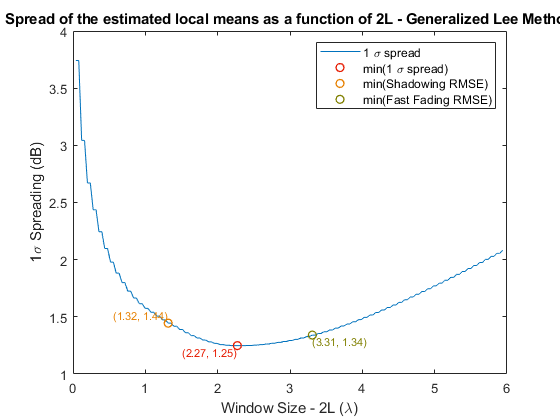

In [14]:
%% Plot 1-sigma Spreading 
figure;
plot((vtW-1)*dMod/lambda,sigmaSpread); hold all;
plot((vtW(minIndxSigma)-1)*dMod/lambda, minSigmaSpread, 'o', 'linewidth', 1, 'Color',[0.9 0.1 0.0])
plot((vtW(minIndx)-1)*dMod/lambda, sigmaSpread(minIndx), 'o', 'linewidth', 1, 'Color',[0.9 0.5 0.0])
plot((vtW(minIndxFast)-1)*dMod/lambda, sigmaSpread(minIndxFast), 'o', 'linewidth', 1, 'Color',[0.5 0.5 0.0])
hold off
pt1 = sprintfc('(%1.2f, %1.2f)', [(vtW(minIndxSigma)-1)*dMod/lambda; minSigmaSpread].');
pt2 = sprintfc('(%1.2f, %1.2f)', [(vtW(minIndx)-1)*dMod/lambda; sigmaSpread(minIndx)].');
pt3 = sprintfc('(%1.2f, %1.2f)', [(vtW(minIndxFast)-1)*dMod/lambda; sigmaSpread(minIndxFast)].');
text((vtW(minIndxSigma)-1)*dMod/lambda, sigmaSpread(minIndxSigma), pt1,'FontSize',8,...
    'color', [0.9 0.1 0.0], 'HorizontalAlignment','right', 'VerticalAlignment','top')
text((vtW(minIndx)-1)*dMod/lambda, sigmaSpread(minIndx), pt2,'FontSize',8,...
    'color', [0.9 0.5 0.0], 'HorizontalAlignment','right', 'VerticalAlignment','bottom')
text((vtW(minIndxFast)-1)*dMod/lambda, sigmaSpread(minIndxFast), pt3,'FontSize',8,...
    'color', [0.5 0.5 0.0], 'HorizontalAlignment','left', 'VerticalAlignment','top')
ylabel('1\sigma Spreading (dB)');
xlabel('Window Size - 2L (\lambda)');
legend('1 \sigma spread', 'min(1 \sigma spread)', 'min(Shadowing RMSE)', 'min(Fast Fading RMSE)');
title("Spread of the estimated local means as a function of 2L - Generalized Lee Method")

### Plot da Função de Correlação

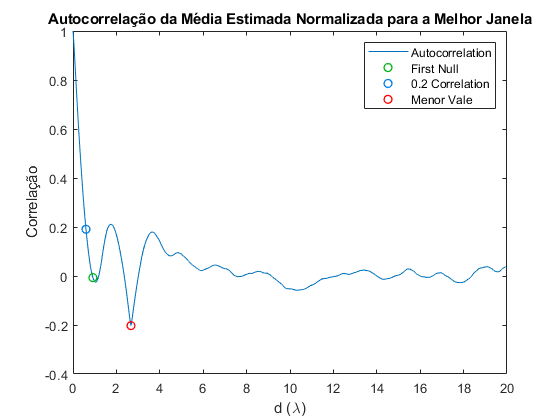

In [13]:
%% Plot Correlação para encontrar "d"
figure;
plot(lagsBW*dMod/lambda,aCorrBestW); hold on
plot((indexD0p0-1)*dMod/lambda,aCorrBestW(indexD0p0), 'o', 'linewidth', 1, 'Color',[0.0 0.7 0.1])
plot((indexD0p2-1)*dMod/lambda,aCorrBestW(indexD0p2), 'o', 'linewidth', 1, 'Color',[0.0 0.5 0.9])
plot(indexD*dMod/lambda,aCorrBestW(indexD+1), 'o', 'linewidth', 1, 'color', 'r')
hold off
ylabel('Correlação');
xlabel('d (\lambda)');
legend('Autocorrelation', 'First Null', '0.2 Correlation', 'Menor Vale');
title("Autocorrelação da Média Estimada Normalizada para a Melhor Janela")

### Plot dos valores de "d" x "2L"

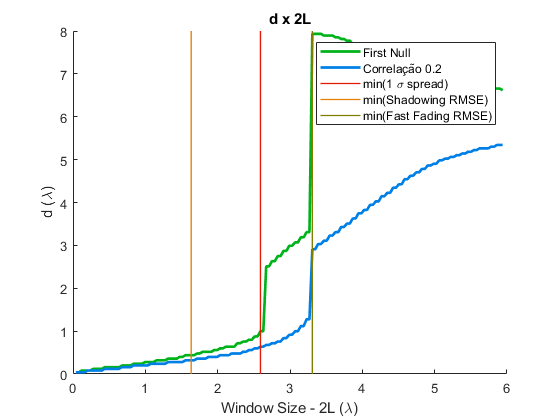

In [14]:
%% Plot "d" x "2L"
figure; hold on
plot((vtW-1)*dMod/lambda,vtD0p0/lambda, 'linewidth', 2, 'Color',[0.0 0.7 0.1])
plot((vtW-1)*dMod/lambda,vtD0p2/lambda, 'linewidth', 2, 'Color',[0.0 0.5 0.9])
y1=get(gca,'ylim');
plot([(vtW(minIndxSigma)-1)*dMod/lambda,(vtW(minIndxSigma)-1)*dMod/lambda],[y1(1), y1(2)], 'linewidth', 1, 'Color',[0.9 0.1 0.0])
plot([(vtW(minIndx)-1)*dMod/lambda,(vtW(minIndx)-1)*dMod/lambda],[y1(1), y1(2)], 'linewidth', 1, 'Color',[0.9 0.5 0.0])
plot([(vtW(minIndxFast)-1)*dMod/lambda,(vtW(minIndxFast)-1)*dMod/lambda],[y1(1), y1(2)], 'linewidth', 1, 'Color',[0.5 0.5 0.0])
hold off
ylabel('d (\lambda)');
xlabel('Window Size - 2L (\lambda)');
legend('First Null', 'Correlação 0.2', 'min(1 \sigma spread)', 'min(Shadowing RMSE)', 'min(Fast Fading RMSE)');
title("d x 2L")

### Plot do RMSE entre os valores dos desvanecimentos do modelo do canal e resultados após filtragem

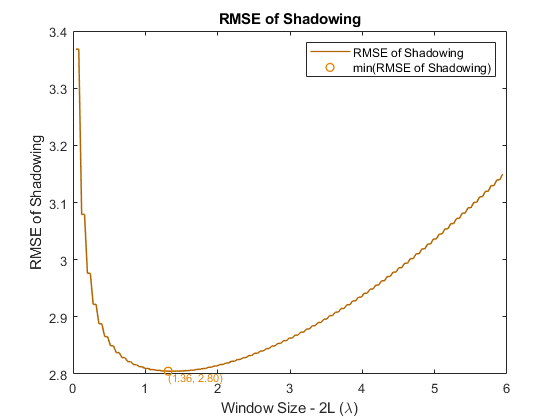

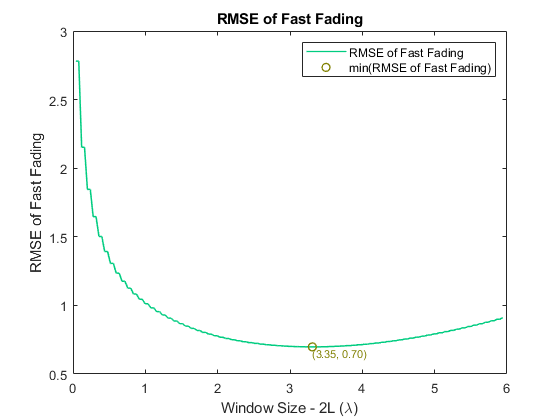

In [16]:
%% Plot do RMSE do sombreamento
figure;
plot((vtW-1)*dMod/lambda,rmseShad,'linewidth', 1, 'Color',[0.7 0.4 0.0]); hold all;
plot((vtW(minIndx)-1)*dMod/lambda, rmseShad(minIndx), 'o', 'linewidth', 1, 'Color',[0.9 0.5 0.0])
pt1 = sprintfc('(%1.2f, %1.2f)', [vtW(minIndx)*dMod/lambda; rmseShad(minIndx)].');
text((vtW(minIndx)-1)*dMod/lambda, rmseShad(minIndx), pt1,'FontSize',8,...
    'color', [0.9 0.5 0.0], 'HorizontalAlignment','left', 'VerticalAlignment','top')
ylabel('RMSE of Shadowing');
xlabel('Window Size - 2L (\lambda)');
legend('RMSE of Shadowing', 'min(RMSE of Shadowing)');
title("RMSE of Shadowing")

%% Plot do RMSE de Pequena Escala
figure;
plot((vtW-1)*dMod/lambda,rmseFastFad,'linewidth', 1,'color',[0.0 0.8 0.5]); hold all;
plot((vtW(minIndxFast)-1)*dMod/lambda, rmseFastFad(minIndxFast), 'o', 'linewidth', 1, 'Color',[0.5 0.5 0.0])
pt1 = sprintfc('(%1.2f, %1.2f)', [vtW(minIndxFast)*dMod/lambda; rmseFastFad(minIndxFast)].');
text((vtW(minIndxFast)-1)*dMod/lambda, rmseFastFad(minIndxFast), pt1,'FontSize',8,...
    'color', [0.5 0.5 0.0], 'HorizontalAlignment','left', 'VerticalAlignment','top')
ylabel('RMSE of Fast Fading');
xlabel('Window Size - 2L (\lambda)');
legend('RMSE of Fast Fading', 'min(RMSE of Fast Fading)');
title("RMSE of Fast Fading")

### Comaparação entre modelo do canal e desvanecimentos após filtragem com a melhor janela  

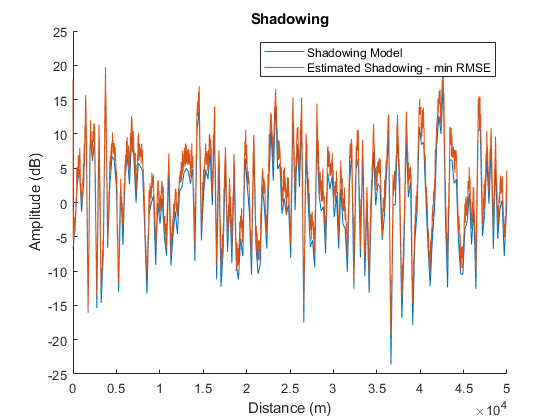

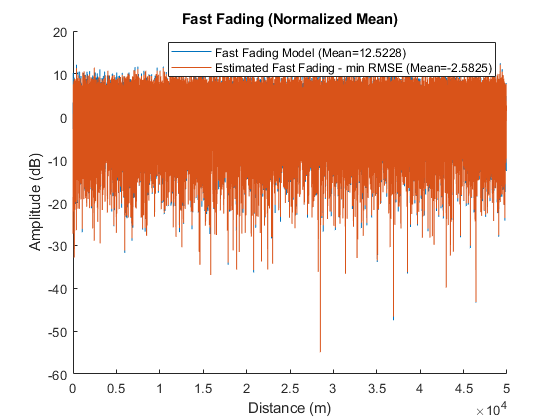

In [17]:
%% Plot dos vetores de Sombreamento
figure;
hold on
plot(vtShadModAjustPlot(minIndx,:))
plot(vtShadowingPlot(minIndx,:))
hold off
ylabel('Amplitude (dB)');
xlabel('Distance (m)');
legend('Shadowing Model', 'Estimated Shadowing - min RMSE');
title("Shadowing")

%% Plot dos vetores de Desvanecimento de Pequena Escala
ffModMean = mean(vtFastModAjustPlot(minIndxFast,:));
ffMean = mean(vtFastFadingPlot(minIndxFast,:));
figure;
hold on
plot(vtFastModAjustPlot(minIndxFast,:)-ffModMean)
plot(vtFastFadingPlot(minIndxFast,:)-ffMean)
hold off
ylabel('Amplitude (dB)');
xlabel('Distance (m)');
legend(strcat('Fast Fading Model (Mean=', num2str(ffModMean), ')'), strcat('Estimated Fast Fading - min RMSE (Mean=', num2str(ffMean), ')'));
title("Fast Fading (Normalized Mean)")